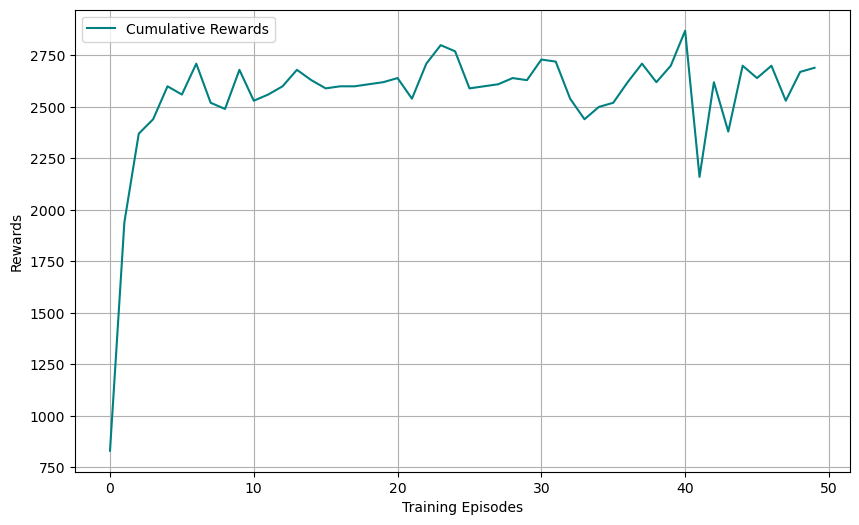

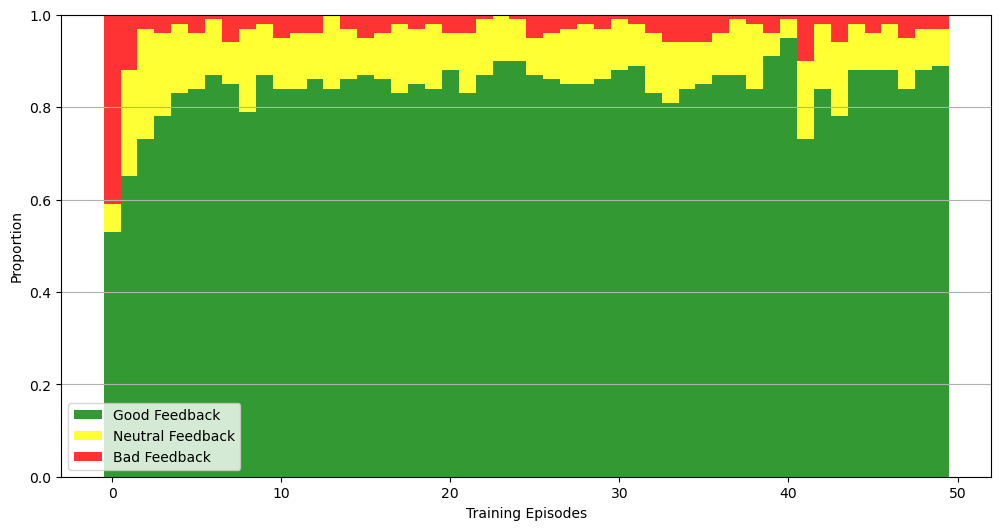

In [39]:
# Script for RLHF on Savings Behavior Optimization

# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RLHFWithSavings:
    def __init__(self, df):
        """
        Initialize the RLHF environment for savings optimization.
        :param df: DataFrame containing income, expenses, current savings, and savings goals.
        """
        self.df = df
        self.state_space = len(df)
        self.action_space = 11  # Actions: 0% to 100% savings (increments of 10%)
        self.q_table = np.zeros((self.state_space, self.action_space))
        self.learning_rate = 0.1
        self.discount_factor = 0.99
        self.epsilon = 0.5
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.05

    def reset(self):
        """Reset the environment to the initial state."""
        self.current_index = 0
        return self.current_index

    def step(self, action):
        """
        Take an action and calculate reward and feedback.
        :param action: Action chosen by the agent (savings percentage index).
        :return: Tuple of next state index, reward, done flag, and feedback.
        """
        row = self.df.iloc[self.current_index]
        suggested_savings = action / 10 * row["income"]
        max_feasible_savings = max(row["income"] - row["expenses"], 0)
        actual_savings = min(suggested_savings, max_feasible_savings)
        final_savings = row["current_savings"] + actual_savings

        # Quantitative reward
        R_quantitative = 0

        # Qualitative feedback
        if max_feasible_savings == 0:
            if actual_savings == 0:
                feedback = "Good"
                R_qualitative = 30
            else:
                feedback = "Bad"
                R_qualitative = -20
        else:
            if actual_savings >= 0.8 * max_feasible_savings:
                feedback = "Good"
                R_qualitative = 30
            elif actual_savings < 0.2 * max_feasible_savings:
                feedback = "Bad"
                R_qualitative = -20
            else:
                feedback = "Neutral"
                R_qualitative = 10

        # Total reward
        reward = R_quantitative + R_qualitative

        # Move to the next state
        self.current_index += 1
        done = self.current_index >= len(self.df)

        return self.current_index, reward, done, {"feedback": feedback}

    def update_q_table(self, state_idx, action, reward, next_state_idx):
        """
        Update Q-table using the Q-learning formula.
        :param state_idx: Current state index.
        :param action: Chosen action.
        :param reward: Observed reward.
        :param next_state_idx: Next state index.
        """
        best_next_action = np.argmax(self.q_table[next_state_idx]) if next_state_idx < self.state_space else 0
        td_target = reward + self.discount_factor * self.q_table[next_state_idx, best_next_action]
        td_error = td_target - self.q_table[state_idx, action]
        self.q_table[state_idx, action] += self.learning_rate * td_error

    def train(self, episodes=50):
        """
        Train the agent using Q-learning and track performance.
        :param episodes: Number of training episodes.
        :return: List of rewards and feedback distributions over episodes.
        """
        rewards_over_time = []
        feedback_counts = {"Good": [], "Neutral": [], "Bad": []}

        epsilon = self.epsilon
        for episode in range(episodes):
            state_idx = self.reset()
            done = False
            episode_rewards = 0
            episode_feedback = {"Good": 0, "Neutral": 0, "Bad": 0}

            while not done:
                # Epsilon-greedy action selection
                if np.random.rand() < epsilon:
                    action = np.random.randint(0, self.action_space)  # Explore
                else:
                    action = np.argmax(self.q_table[state_idx])  # Exploit

                next_state_idx, reward, done, info = self.step(action)
                if not done:
                    self.update_q_table(state_idx, action, reward, next_state_idx)
                state_idx = next_state_idx
                episode_rewards += reward
                episode_feedback[info["feedback"]] += 1

            rewards_over_time.append(episode_rewards)
            for key in feedback_counts.keys():
                feedback_counts[key].append(episode_feedback.get(key, 0))

            epsilon = max(self.epsilon_min, epsilon * self.epsilon_decay)

        return rewards_over_time, feedback_counts

# Generate synthetic financial data
np.random.seed(42)
batch_size = 100
data = {
    "income": np.random.randint(800, 2000, size=batch_size),
    "expenses": np.random.randint(500, 1500, size=batch_size),
    "current_savings": np.random.randint(1000, 5000, size=batch_size),
    "savings_goal": np.random.randint(5000, 10000, size=batch_size),
}
df = pd.DataFrame(data)

# Initialize and train the RLHF environment
rlhf_env = RLHFWithSavings(df)
rewards, feedback_trends = rlhf_env.train(episodes=50)

# Plot cumulative rewards
n_episodes = 50
plt.figure(figsize=(10, 6))
plt.plot(rewards[0:n_episodes], label="Cumulative Rewards", color="teal")
# plt.title("Cumulative Rewards During RLHF Training")
plt.xlabel("Training Episodes")
plt.ylabel("Rewards")
plt.legend()
plt.grid(True)
plt.show()

# Feedback trends visualization
episodes = np.arange(len(feedback_trends["Good"]))
total_feedback = np.array([
    np.array(feedback_trends["Good"]),
    np.array(feedback_trends["Neutral"]),
    np.array(feedback_trends["Bad"])
])
proportions = total_feedback / total_feedback.sum(axis=0)

plt.figure(figsize=(12, 6))
plt.bar(episodes[0:n_episodes], proportions[0][0:n_episodes], label="Good Feedback", color="green", width=1.0, alpha=0.8)
plt.bar(episodes[0:n_episodes], proportions[1][0:n_episodes], bottom=proportions[0][0:n_episodes], label="Neutral Feedback", color="yellow", width=1.0, alpha=0.8)
plt.bar(episodes[0:n_episodes], proportions[2][0:n_episodes], bottom=proportions[0][0:n_episodes] + proportions[1][0:n_episodes], label="Bad Feedback", color="red", width=1.0, alpha=0.8)
# plt.title("Proportions of Feedback Types Over Episodes")
plt.xlabel("Training Episodes")
plt.ylabel("Proportion")
plt.legend()
plt.grid(True, axis="y")
plt.show()


In [41]:
# Extract the final Q-table and associate it with state information
q_table_final = rlhf_env.q_table
q_table_df = pd.DataFrame(q_table_final, columns=[f"Action {i*10}%" for i in range(rlhf_env.action_space)])
q_table_df["Best Action"] = q_table_df.idxmax(axis=1)

# Combine state information with the Q-table
final_q_table = pd.concat([df, q_table_df], axis=1)

final_q_table.head()

,income,expenses,current_savings,savings_goal,Action 0%,Action 10%,Action 20%,Action 30%,Action 40%,Action 50%,Action 60%,Action 70%,Action 80%,Action 90%,Action 100%,Best Action
0,1926,1339,2257,5262,7.621655,7.850364,16.262440,17.370897,0.000000,21.211946,23.144266,74.839228,16.672322,30.832900,5.385786,Action 70%
1,1660,1279,1683,5623,6.148846,15.088019,8.417312,12.197053,5.166976,20.282598,0.000000,20.550931,73.468072,21.884631,8.930066,Action 80%
2,1930,1429,1663,6016,6.895380,6.614745,5.971435,7.799913,22.112062,0.000000,31.430942,14.713383,4.879277,8.326855,69.850951,Action 100%
3,1895,532,2998,8643,3.544328,1.135684,15.998151,2.494345,4.402992,1.484229,64.341281,18.883674,6.911177,14.706559,0.000000,Action 60%
4,1844,547,4898,9976,1.334392,7.691971,5.738279,8.586943,4.923962,60.634264,40.745419,9.301615,0.000000,8.952740,0.000000,Action 50%


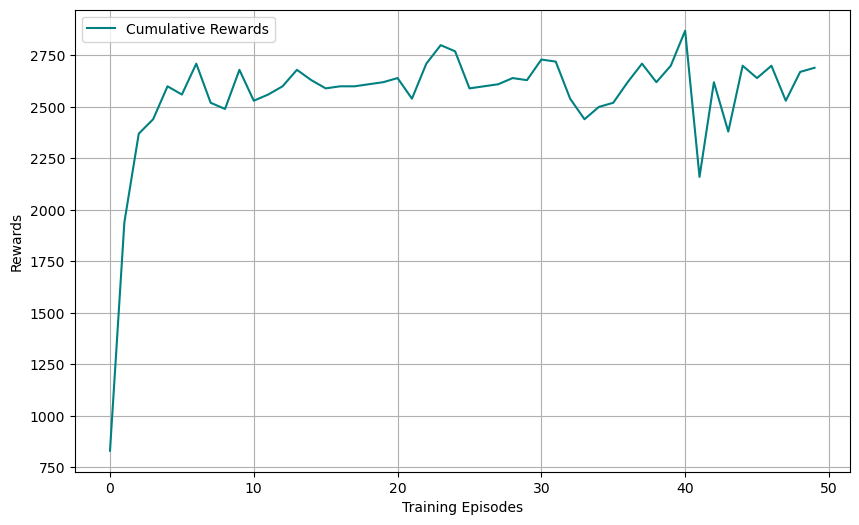

In [43]:
# Plot cumulative rewards
n_episodes = 50
plt.figure(figsize=(10, 6))
plt.plot(rewards[0:n_episodes], label="Cumulative Rewards", color="teal")
# plt.title("Cumulative Rewards During RLHF Training")
plt.xlabel("Training Episodes")
plt.ylabel("Rewards")
plt.legend()
plt.grid(True)
plt.show()

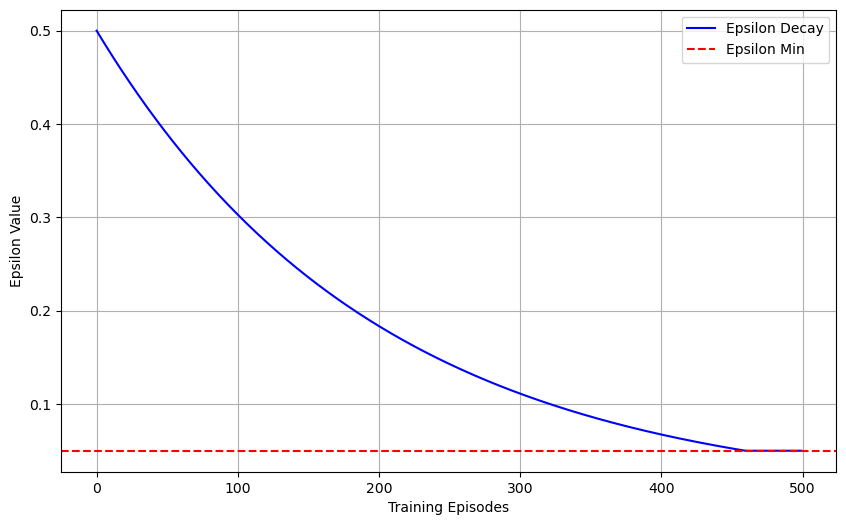

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for epsilon decay
initial_epsilon = 0.5
epsilon_min = 0.05
epsilon_decay = 0.995
episodes = 500

# Calculate epsilon values over episodes
epsilon_values = [initial_epsilon]
current_epsilon = initial_epsilon
for _ in range(1, episodes):
    current_epsilon = max(epsilon_min, current_epsilon * epsilon_decay)
    epsilon_values.append(current_epsilon)

# Plot epsilon decay
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values, label="Epsilon Decay", color="blue")
# plt.title("Epsilon Decay Over Training Episodes")
plt.xlabel("Training Episodes")
plt.ylabel("Epsilon Value")
plt.axhline(y=epsilon_min, color="red", linestyle="--", label="Epsilon Min")
plt.legend()
plt.grid(True)
plt.show()
